# Machine Learning Challenge - Etermax

### Enunciado aquí

## Imports


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Data exploration



We have to open up this dataset a little bit to see what it has inside.

### Opening up the dataset

In [3]:
df = pd.read_csv("dataset.csv")
df.tail()

user_id country country_region  ... event_2 event_3   revenue
19995  eeab2381      br      Sao Paulo  ...       0     1.0  0.001172
19996  4b9519ab      ca        Ontario  ...       0     1.0  0.005385
19997  a72c1647      es       Valencia  ...       0     0.0  0.000000
19998  5ca2b3f1      es         Madrid  ...       0     0.0  0.000000
19999  e5064a8a      es     Valladolid  ...       5     0.0  0.012407

[5 rows x 11 columns]

### First thoughts

We have 10 columns, most of which are categorical (strings). Random thoughts, as a braistorming, before analyzing them:

- **user_id** seems like a random indicator, unlinked to other variables. If we already knew each and every single one of our users, it could be useful, but that looks costly. I will check out if there are any repeated users.
- **country** could be a strong candidate to quantify revenue.
- **country_region** also could be a strong indicator. It is important to check the health of it, because this could lead to a lot of categories.
- **source** seems to be a binary valuable with a really strong meaning: are users that look up the game for themselves spending bigger than users we get from ads?
- **platform** is another binary, strong contender parameter: do iOS users spend more?
- **device_family** seems like a tough one. i think i might have a trick to change it to way lesser categories and a more meaningful indicator. i'm going to grab the first word (like motorola, in the case of what's shown above), and with it, a histogram to check for brands and importance.
- **os_version** could have information -newer OS means newer phone- but I don't know how hard the impact may be.
- **event**s might have quantitative information on revenew. event_3 seems to be float, and events are indivisible, so there's that.
- **revenue** is our objective!

I will ask some simple questions on the characteristics of this database to see where it leads me.

**Note that this is a playground - an exploratory journey throughout my own thoughts. Proceed with caution.**

In [4]:
print("How many different users do we have?", df["user_id"].nunique())
print("How many different countries?", df["country"].nunique())
print("How many different regions?", df["country_region"].nunique())
print("Do we have two sources?", df["source"].nunique() == 2)
print("Do we have two platforms?", df["platform"].nunique() == 2)
print("What about two platforms... in lowercase?", df["platform"].str.lower().nunique() == 2)
print("How many different devices do we have?", df["device_family"].nunique())
print("And... how many brands?", df['device_family'].str.split(' ').str[0].str.lower().nunique())
print("How many OS versions?", df["os_version"].nunique())
print("How many OS main versions?", df["os_version"].str.split('.').str[0].nunique())


How many different users do we have? 20000
How many different countries? 91
How many different regions? 680
Do we have two sources? True
Do we have two platforms? False
What about two platforms... in lowercase? True
How many different devices do we have? 982
And... how many brands? 149
How many OS versions? 82
How many OS main versions? 10


### Quantitative analysis

After these questions, let's look at our quantitative fields:

In [5]:
df.describe(percentiles = [0.2*i for i in range(5)])

event_1       event_2       event_3       revenue
count  20000.000000  20000.000000  19601.000000  20000.000000
mean       3.019350     53.023500      3.994439     29.596330
std       72.631306    119.469538     18.325468    849.034984
min        0.000000      0.000000      0.000000      0.000000
0%         0.000000      0.000000      0.000000      0.000000
20%        0.000000      0.000000      0.000000      0.000000
40%        0.000000      0.000000      0.000000      0.002217
50%        0.000000      5.000000      0.000000      0.011877
60%        0.000000     16.000000      0.000000      0.035622
80%        0.000000     76.000000      2.000000      0.166925
max     4879.000000   2694.000000    643.000000  68838.563100

A mean of almost 30, an standard deviaton of almost 850 and 90th percetile of 0.36. This is a really, really asymmetric distribution. Let's do a histogram. 30% of people just do not give any revenue. And that makes sense. 

[]

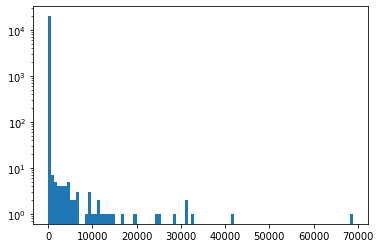

In [6]:
plt.hist(df["revenue"], log=True, bins=100)
plt.plot()

I plotted it on a log scale on purpose. I saw the max, and the 90th percentile, and knew something was up. A quick remark: I played mobile games when I was younger. At first, I thought "well, that 68k might have been bad data." But it's not. They are the whales, that spend lots and lots of money in ingame purchases. Whale spending might snowball whale communities (see, as an example, Summoner's War). One would expect that most of the money would come from ads... but there are also the whales. Obviously, what I'd like to do is see how much money the whales are giving to our company compared to F2P gamers. Let me define, ad hoc, big spenders as those who spend more than a dollar. 


In [7]:
print(f"{df['revenue'][df['revenue']>1].count()} users, with more than 1 revenue, generate {df['revenue'][df['revenue']>1].sum()}")
print(f"{df['revenue'][df['revenue']<1].count()} users, with less than 1 revenue, generate {df['revenue'][df['revenue']<1].sum()}")

464 users, with more than 1 revenue, generate 590132.9962190001
19536 users, with less than 1 revenue, generate 1793.611829


The big spenders are clearly the ones who make the money for the company (two and a half orders of mangitude!), so I need some sort of distribution (like a pareto one) to explore this further. Nevertheless, I want to further analyze the small spenders first, because the big spenders are pretty much outliers. They clearly don't generate as much revenue, but represent the "normal" behaviour of clients. To be able to train a model, we must eliminate the outliers - they can really modify what's expected.

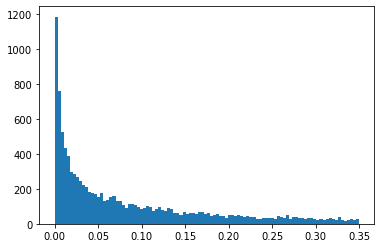

In [8]:
plt.hist(df["revenue"][df["revenue"]>0], range=(0, 0.35), log=False, bins=100)
plt.show()

### Relation between variables.

Let's now study correlation between variables.

In [9]:
df.corr(method='spearman')

event_1   event_2   event_3   revenue
event_1  1.000000  0.051245  0.024190  0.048194
event_2  0.051245  1.000000  0.557744  0.967033
event_3  0.024190  0.557744  1.000000  0.622867
revenue  0.048194  0.967033  0.622867  1.000000

I used spearman because there's no way we assume our distributions are normal. They look... Poissonian, with outliers as whales. 

It seems that event_2 has a lot of correlation with revenue, so we have to watch out on it. event_3 has a little bit of information. event_1 is pretty much ignorable. 

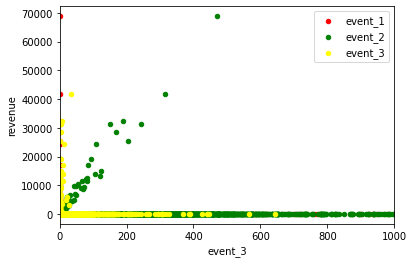

In [36]:
ax = df.plot.scatter(x="event_1", y="revenue", xlim=(0, 1000), c="red", label="event_1" )
df.plot.scatter(x="event_2", y="revenue", ax=ax, c="green", label="event_2")
df.plot.scatter(x="event_3", y="revenue", ax=ax, c="yellow", label="event_3")

This plot shows us a little bit of things: there's a big correlation between high spending and event_2. event_1 doesn't seem to have almost any correlation. event_3 seems to have some information over the buying. I will plot now something closer to the origin:

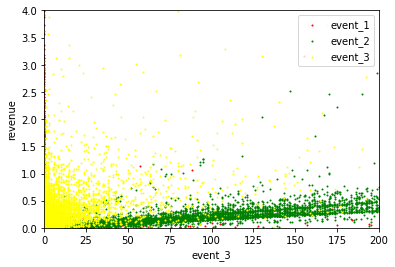

In [56]:
ax = df.plot.scatter(x="event_1", y="revenue", ylim=(0, 4), xlim=(0, 200), c="red", s=1, label="event_1")
df.plot.scatter(x="event_2", y="revenue", ax=ax, c="green", s=1, label="event_2")
df.plot.scatter(x="event_3", y="revenue", ax=ax, c="yellow", s=1, label="event_3")

Quick analysis:

- event_1 doens't seem to give much information
- event_2 has a really strong, lineal correlation, especially on a big number of events. But it has information on small spenders.
- event_2 doens't have a really strong correlation, but it seems that it drives the revenue on the bigger spenders (though a lot of events)

In [39]:
df.groupby( df["source"])["revenue"].describe()

count       mean         std  ...       50%       75%           max
source                                       ...                                  
Non-Organic   4792.0   0.089285    0.230169  ...  0.002817  0.058955      3.125596
Organic      14391.0  40.161855  998.455413  ...  0.018516  0.133520  68838.563100

[2 rows x 8 columns]

This one seems like a big deal. Most whales come from an organic source - that is, people coming from adds do not spend as much as those outliers who spend a lot.


### Missing data

It is important to know which variables usually lack information, and how to handle it.

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
source            817  0.04085
country_region    634  0.03170
event_3           399  0.01995
os_version          1  0.00005
device_family       1  0.00005
revenue             0  0.00000
event_2             0  0.00000
event_1             0  0.00000
platform            0  0.00000
country             0  0.00000
user_id             0  0.00000

From our previous exploratory analysis, country_region doesn't seem to be really important, source has a lot of information as a classifier, and event_3 has information on revenew.

## Data preprocessing

So, we know some things about our dataset, and from there on, we can search on tactics to correctly pipeline and preprocess the data we're trying to use for training and estimating. We have some sort of **Poisson distribution**, or even moreso, a **negative binomial distribution**: most people doesn't spend any money. We can't attack this as a normal distribution problem. And that's nice.


### Columns

Each column need a little bit of preprocessing:


- **user_id**  could be dropped. We have 20k columns and 20k different user ids.
- **country** must be converted to a "categorical" type feature.
- **country_region** must be converted to a "categorical" type feature... and might be dropped (too many categories).
- **source** has to be considered. It is also categorical.
- **platform** must be converted to lowercase and the into a category.
- **device_family** a lot of brands that could be listed as categories. First of all, I take the first word to get the brand. Then, I lowercase it.
- **os_version**  I should just take the first number to check for the main OS version.
- **event**s are quantitative. I will just set event_3 to integer, because events are discrete.

Categorical data can handle a missing value as an additional category. Missing data in quantitative columns can be seen as a zero (or it could even be filled with the mean - but I will fill with zeros).

I will create a nice, neat reusable preprocessing function to be reused in the microservice later (incoming data must be also preprocessed).

### Outliers

What should I do with outliers? There might be two important metrics to focus on:

- How important are individual estimations?
- How important is the total estimation?

I can make two kind of models: one that optimizes its predictions for the total revenue (where outliers have a lot of weight) or another one that optimizes its predictions for unitary revenue (where outliers heavily impact our predictions). I will work on both models and then I will make a choice. Nevertheless, this is something that would be lovely to discuss with other data scientists, and with the Product department.


In [3]:
df = pd.read_csv("dataset.csv")
droppable_columns = ["user_id"]
categorical_columns = ["country", "country_region", "source", "platform", "device_family", "os_version"]
integer_columns = ["event_1", "event_2", "event_3"]
objective = "revenue"

def log_transform(x):
  '''
  Logarithmic space transform function. 
  '''
  return np.log(x+1)

def log_antitransform(x):
  return np.exp(x)-1

def predict(model, antitransform, x):
  return antitransform(model.predict(x))

def preprocessing(dataframe, droppable_columns, integer_columns, categorical_columns, objective, transform=None):
  '''
  Preprocessing function for the proposed dataframe.

  This functions modifies the dataframe to get categorical columns from strings,
  dropping non-informative columns, and converting float columns into integer columns.

  For categorical columns, it only takes the first word in lowercase. For integer columns,
  it fills NaN values with zero.

  Parameters
  ----------
  dataframe : pandas.dataframe
      The dataframe to process.
  droppable_columns : list
      List of droppable column strings.
  integer_columns : list
      List of integer column strings.
  categorical_columns : list
      List of categorical column strings.

  Returns
  -------
  dataframe : pandas.dataframe
      Preprocessed dataframe.
'''
  
  for c in droppable_columns:
    dataframe = dataframe.drop(c, axis="columns")
  for c in categorical_columns:
    dataframe[c] = dataframe[c].str.split(' ').str[0].str.lower()
    dataframe[c] = dataframe[c].astype("category", copy=False)
  for c in integer_columns:
    dataframe[c] = dataframe[c].fillna(0)
    dataframe[c] = dataframe[c].astype("int64", copy=False)
  if transform:
    return dataframe.drop(objective, axis="columns"), transform(dataframe[objective])
  return dataframe.drop(objective, axis="columns"), dataframe[objective]

df, obj = preprocessing(df, droppable_columns, integer_columns, categorical_columns, objective, log_transform)
df.dtypes


country           category
country_region    category
source            category
platform          category
device_family     category
os_version        category
event_1              int64
event_2              int64
event_3              int64
dtype: object

## Model selection and training

### Whales

Due to whales having the biggest impact in this dataset, their importance for the total revenue should not be avoided. [Forbes even wrote about their revenue importance](https://www.forbes.com/sites/insertcoin/2014/03/01/why-its-scary-when-0-15-mobile-gamers-bring-in-50-of-the-revenue/?sh=582b39f74065). Therefore, I will create two models:

- A model that is able to estimate the spending a gamer will do, including whales, so as to have the total spending as a metric. This won't use a log transform.
- A model that is able to estimate the spending a gamer will do, excluding whales, so as to have the unitary spending as a metric. This will use a log transform.

In both cases we are in front of a poisson-regression problem, therefore, we can use some sort of decision tree schematic to solve it. And currently, the king seems to be LightGBM [(medium post on it)](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc).

I will try these two models now.


#### Total estimation - big weight to whales

I won't use any transform to modify the prediction space.

#### Unitary estimation - low spenders

The best preprocessing I could came out with is taking the old trick of doing $$\hat{y}_{train} \to \log(y_{train}+1)$$

to take a better fit of the parameters. Then, once I make a prediction, I can obtain thre predicted $y$ as:

$$y_{pred} = \exp(\hat{y}) -1  $$

This makes the problem a bit more manageable. Let's look at how this works.


### First experiment - normal space

In [66]:
import lightgbm
from sklearn.model_selection import train_test_split
df = pd.read_csv("dataset.csv")

droppable_columns = ["user_id"]
categorical_columns = ["country", "country_region", "source", "platform", "device_family", "os_version"]
integer_columns = ["event_1", "event_2", "event_3"]
objective = "revenue"

x, y = preprocessing(df, droppable_columns, integer_columns, categorical_columns, objective)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #the answer to everything

train_data = lightgbm.Dataset(x_train, label=y_train, categorical_feature=categorical_columns)
test_data = lightgbm.Dataset(x_test, label=y_test)



In [67]:
parameters = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'metric': ['poisson'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "silent": True,
    "num_iterations": 100000,
    "n_estimators": 1000

}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['country', 'country_region', 'device_family', 'os_version', 'platform', 'source']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:76

[1]	valid_0's poisson: -129.237
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's poisson: -144.12
[3]	valid_0's poisson: -152.983
[4]	valid_0's poisson: -159.659
[5]	valid_0's poisson: -166.057
[6]	valid_0's poisson: -171.242
[7]	valid_0's poisson: -175.008
[8]	valid_0's poisson: -178.866
[9]	valid_0's poisson: -182.22
[10]	valid_0's poisson: -185.118
[11]	valid_0's poisson: -188.976
[12]	valid_0's poisson: -192.329
[13]	valid_0's poisson: -195.036
[14]	valid_0's poisson: -197.839
[15]	valid_0's poisson: -199.941
[16]	valid_0's poisson: -202.13
[17]	valid_0's poisson: -204.059
[18]	valid_0's poisson: -205.875
[19]	valid_0's poisson: -207.58
[20]	valid_0's poisson: -209.185
[21]	valid_0's poisson: -210.641
[22]	valid_0's poisson: -211.954
[23]	valid_0's poisson: -213.189
[24]	valid_0's poisson: -214.422
[25]	valid_0's poisson: -215.651
[26]	valid_0's poisson: -216.831
[27]	valid_0's poisson: -217.898
[28]	valid_0's poisson: -218.998
[29]	valid_0's poisson: -2

Total predicted revenue: 129806.59345444708, Total real revenue: 140247.220273


[]

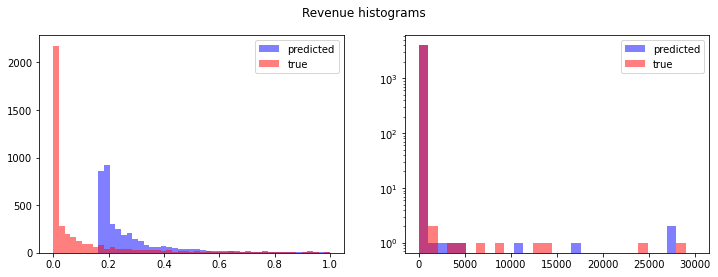

In [82]:
y_predicted = model.predict(x_test)
print(f"Total predicted revenue: {y_predicted.sum()}, Total real revenue: {y_test.values.sum()}")

bins = np.linspace(0,1, 50)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12,4))
fig.suptitle('Revenue histograms')

ax1.hist(y_predicted, bins=bins, alpha=0.5, color="blue", label="predicted")
ax1.hist(y_test, bins=bins, alpha = 0.5, color="red", label="true")
ax1.legend()

bins = np.linspace(0,30000, 30)
ax2.hist(y_predicted, bins=bins, log=True, alpha=0.5, color="blue", label="predicted")
ax2.hist(y_test, bins=bins, log=True, alpha = 0.5, color="red", label="true")
ax2.legend()
plt.plot()

So, what we're looking at is that we have a neat total revenue estimation (130k vs 140k, which is not far not bad), but we're finding the wrong distribution: It has a lot of cases the 0.2 range, and it doesn't seem to acknwodelegde that there are a lot of cases in zero. Let's try a feature importance modification:

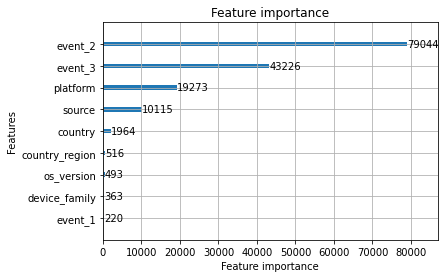

In [83]:
lightgbm.plot_importance(model)

Just as we thought! event_2 and event_3 are, almost by far, the ones meaning the most to this model. platform and source come near. From country onwards, the (high cardinality!) categories doesn't seem to matter much. Let's eliminate them and retrain our model. 

In [10]:
import lightgbm
from sklearn.model_selection import train_test_split
df = pd.read_csv("dataset.csv")

droppable_columns = ["user_id", "event_2", "country", "country_region", "device_family", "os_version"]
categorical_columns = ["source", "platform"]
integer_columns = ["event_1", "event_3"]
objective = "revenue"

x, y = preprocessing(df, droppable_columns, integer_columns, categorical_columns, objective)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #the answer to everything

train_data = lightgbm.Dataset(x_train, label=y_train, categorical_feature=categorical_columns)
test_data = lightgbm.Dataset(x_test, label=y_test)

parameters = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'metric': ['poisson'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "silent": True,
    "num_iterations": 100000,
    "n_estimators": 1000

}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

y_predicted = model.predict(x_test)
print(f"Total predicted revenue: {y_predicted.sum()}, Total real revenue: {y_test.values.sum()}")


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['platform', 'source']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overrid

[1]	valid_0's poisson: -89.0548
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's poisson: -88.9933
[3]	valid_0's poisson: -89.0457
[4]	valid_0's poisson: -89.0862
[5]	valid_0's poisson: -89.0249
[6]	valid_0's poisson: -89.1806
[7]	valid_0's poisson: -89.3325
[8]	valid_0's poisson: -89.2716
[9]	valid_0's poisson: -89.2107
[10]	valid_0's poisson: -89.1497
[11]	valid_0's poisson: -89.0999
[12]	valid_0's poisson: -89.0557
[13]	valid_0's poisson: -89.117
[14]	valid_0's poisson: -89.1566
[15]	valid_0's poisson: -89.1121
[16]	valid_0's poisson: -89.1716
[17]	valid_0's poisson: -89.1279
[18]	valid_0's poisson: -89.167
[19]	valid_0's poisson: -89.1172
[20]	valid_0's poisson: -89.0674
[21]	valid_0's poisson: -89.2859
[22]	valid_0's poisson: -89.3229
[23]	valid_0's poisson: -89.4043
[24]	valid_0's poisson: -89.63
[25]	valid_0's poisson: -89.7035
[26]	valid_0's poisson: -89.7402
[27]	valid_0's poisson: -89.81
[28]	valid_0's poisson: -89.9967
[29]	valid_0's poisson: -90.

[]

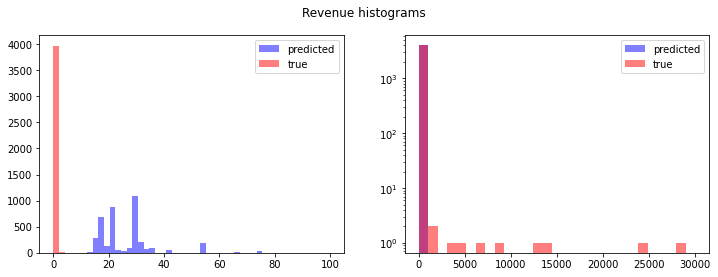

In [11]:

bins = np.linspace(0,100, 50)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12,4))
fig.suptitle('Revenue histograms')

ax1.hist(y_predicted, bins=bins, alpha=0.5, color="blue", label="predicted")
ax1.hist(y_test, bins=bins, alpha = 0.5, color="red", label="true")
ax1.legend()

bins = np.linspace(0,30000, 30)
ax2.hist(y_predicted, bins=bins, log=True, alpha=0.5, color="blue", label="predicted")
ax2.hist(y_test, bins=bins, log=True, alpha = 0.5, color="red", label="true")
ax2.legend()
plt.plot()

Eliminating those features didn't do any good to our model. It seems to have... unlearnt a lot. The total estimate is still pretty good, but it is a lot different than the one we first trained.

#### Logarithmic space transform

Let's try the log transform trick to see if it leads us to a better model fitting.

In [12]:
import lightgbm
from sklearn.model_selection import train_test_split
df = pd.read_csv("dataset.csv")

droppable_columns = ["user_id"]
categorical_columns = ["country", "country_region", "source", "platform", "device_family", "os_version"]
integer_columns = ["event_1", "event_2", "event_3"]
objective = "revenue"

x, y = preprocessing(df, droppable_columns, integer_columns, categorical_columns, objective, log_transform)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #the answer to everything

train_data = lightgbm.Dataset(x_train, label=y_train, categorical_feature=categorical_columns)
test_data = lightgbm.Dataset(x_test, label=y_test)


model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['country', 'country_region', 'device_family', 'os_version', 'platform', 'source']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:76

Se han truncado las últimas 5000 líneas del flujo de salida.
[113]	valid_0's poisson: 0.278381
[114]	valid_0's poisson: 0.277871
[115]	valid_0's poisson: 0.277365
[116]	valid_0's poisson: 0.276865
[117]	valid_0's poisson: 0.276375
[118]	valid_0's poisson: 0.27589
[119]	valid_0's poisson: 0.275404
[120]	valid_0's poisson: 0.274924
[121]	valid_0's poisson: 0.274522
[122]	valid_0's poisson: 0.274106
[123]	valid_0's poisson: 0.273725
[124]	valid_0's poisson: 0.273365
[125]	valid_0's poisson: 0.272995
[126]	valid_0's poisson: 0.272599
[127]	valid_0's poisson: 0.27222
[128]	valid_0's poisson: 0.271955
[129]	valid_0's poisson: 0.27158
[130]	valid_0's poisson: 0.271208
[131]	valid_0's poisson: 0.270781
[132]	valid_0's poisson: 0.270489
[133]	valid_0's poisson: 0.270071
[134]	valid_0's poisson: 0.269657
[135]	valid_0's poisson: 0.269247
[136]	valid_0's poisson: 0.268965
[137]	valid_0's poisson: 0.268561
[138]	valid_0's poisson: 0.26816
[139]	valid_0's poisson: 0.267762
[140]	valid_0's poisson: 

Total predicted revenue: 40355.53960378317, Total real revenue: 140247.220273


[]

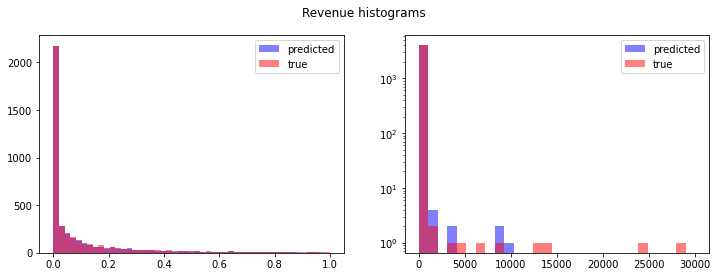

In [13]:

y_predicted = predict(model, log_antitransform, x_test)
y_true = log_antitransform(y_test)
print(f"Total predicted revenue: {y_predicted.sum()}, Total real revenue: {y_true.values.sum()}")

bins = np.linspace(0,1, 50)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12,4))
fig.suptitle('Revenue histograms')

ax1.hist(y_predicted, bins=bins, alpha=0.5, color="blue", label="predicted")
ax1.hist(y_true, bins=bins, alpha = 0.5, color="red", label="true")
ax1.legend()

bins = np.linspace(0,30000, 30)
ax2.hist(y_predicted, bins=bins, log=True, alpha=0.5, color="blue", label="predicted")
ax2.hist(y_true, bins=bins, log=True, alpha = 0.5, color="red", label="true")
ax2.legend()
plt.plot()

In this model we're not being able to predict the whales (who make much of the company revenue), and therefore, the total predicted revenue is way lower. But nevertheless, the distribution learnt looks a lot more like the real one, leaving the outliers... outside. Let's look on feature importance:



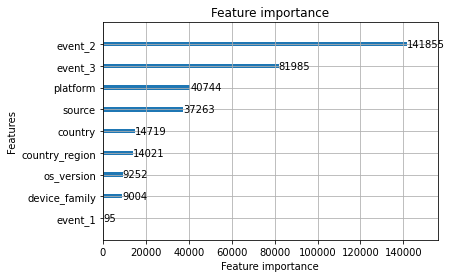

In [14]:
lightgbm.plot_importance(model)

Again, event_2 is -by far- the most important feature. In this case, every single feature seems to have information on the user (but event_1), so eliminating them could be troublesome. Let's try to lower the cardinality of the categories by taking out device_family, os_version and country_region.

In [15]:
df = pd.read_csv("dataset.csv")
droppable_columns = ["user_id", "device_family", "os_version", "event_1", "country_region"]
categorical_columns = ["platform", "source", "country"]
integer_columns = ["event_2", "event_3"]
#long live code reusability
x, y = preprocessing(df, droppable_columns, integer_columns, categorical_columns, objective, log_transform)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #the answer to everything

train_data = lightgbm.Dataset(x_train, label=y_train, categorical_feature=categorical_columns)
test_data = lightgbm.Dataset(x_test, label=y_test)

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['country', 'platform', 'source']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict

Se han truncado las últimas 5000 líneas del flujo de salida.
[3083]	valid_0's poisson: 0.176022
[3084]	valid_0's poisson: 0.176022
[3085]	valid_0's poisson: 0.176021
[3086]	valid_0's poisson: 0.176021
[3087]	valid_0's poisson: 0.17602
[3088]	valid_0's poisson: 0.17602
[3089]	valid_0's poisson: 0.176018
[3090]	valid_0's poisson: 0.176019
[3091]	valid_0's poisson: 0.176018
[3092]	valid_0's poisson: 0.176018
[3093]	valid_0's poisson: 0.176016
[3094]	valid_0's poisson: 0.176016
[3095]	valid_0's poisson: 0.176016
[3096]	valid_0's poisson: 0.176016
[3097]	valid_0's poisson: 0.176014
[3098]	valid_0's poisson: 0.176014
[3099]	valid_0's poisson: 0.176013
[3100]	valid_0's poisson: 0.176012
[3101]	valid_0's poisson: 0.176012
[3102]	valid_0's poisson: 0.176012
[3103]	valid_0's poisson: 0.176011
[3104]	valid_0's poisson: 0.176011
[3105]	valid_0's poisson: 0.17601
[3106]	valid_0's poisson: 0.17601
[3107]	valid_0's poisson: 0.176009
[3108]	valid_0's poisson: 0.176009
[3109]	valid_0's poisson: 0.17600

Total predicted revenue: 19702.173084238293, Total real revenue: 140247.220273


[]

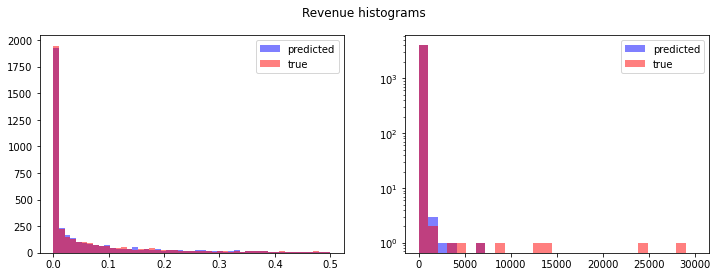

In [17]:

y_predicted = predict(model, log_antitransform, x_test)
y_true = log_antitransform(y_test)
print(f"Total predicted revenue: {y_predicted.sum()}, Total real revenue: {y_true.values.sum()}")

bins = np.linspace(0,0.5, 50)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12,4))
fig.suptitle('Revenue histograms')

ax1.hist(y_predicted, bins=bins, alpha=0.5, color="blue", label="predicted")
ax1.hist(y_true, bins=bins, alpha = 0.5, color="red", label="true")
ax1.legend()

bins = np.linspace(0,30000, 30)
ax2.hist(y_predicted, bins=bins, log=True, alpha=0.5, color="blue", label="predicted")
ax2.hist(y_true, bins=bins, log=True, alpha = 0.5, color="red", label="true")
ax2.legend()
plt.plot()

So we are further away from the total real revenue, but it still knows the probability distribution well enough to be able to yield useful information.

### Model selection

Once we tried the different approaches for our model, we should check some heuristics to define which one we should use. Are we looking for a good total spending estimate? Or do we look at the individual predictions?

I think the second approach is better. Now, we're going to see what the model performance looks like and then -if it works well enough- deploy it.

## Performance evaluation

Here we should try to work on timing.